In [216]:
import httpx
import os
import json
import time
import pandas as pd
from client_v1.settings import EmmRetrieversSettings
from client_v1.jrc_openai import JRCChatOpenAI
from client_v1.formatting_utils import fixed_width_wrap, format_docs, format_doc_minimal
from langchain_core.prompts import ChatPromptTemplate
from utils import iso3_to_iso2, generate_date_ranges, process_documents, add_sections_as_columns
from openai import OpenAI
from httpx import ReadTimeout
from utils import process_graph, process_storyline, custom_sum, extract_disaster_info
from llm_utils import ensemble_graph
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

In [5]:
#model = "nous-hermes-2-mixtral-8x7b-dpo"
model = "llama-3.3-70b-instruct"

In [6]:

def gpt_graph(prompt):
    completion = client1.chat.completions.create(
        model=model,  # Replace with the appropriate model for your use case
        messages=[
        {"role": "system", "content": "You are a disaster manager expert in risk dynamics."},
        {
            "role": "user",
            "content": prompt,
        }
    ]
    )

    # Extract the content from the response
    message_content = completion.choices[0].message.content
    return message_content


apindex = {"2014":'mine_e_emb16-e1f7_prod4_2014', "2015":'mine_e_emb16-e1f7_prod4_2015', "2016":'mine_e_emb16-e1f7_prod4_2016', "2017":'mine_e_emb16-e1f7_prod4_2017',
           "2018":'mine_e_emb16-e1f7_prod4_2018', "2019":'mine_e_emb16-e1f7_prod4_2019', "2020":'mine_e_emb16-e1f7_prod4_2020'}

EMM_RETRIEVERS_API_BASE="https://api.emm4u.eu/retrievers/v1"
with open('./data/emm_token.json', 'r') as file:
    config = json.load(file)
    EMM_RETRIEVERS_API_KEY = config['EMM_RETRIEVERS_API_KEY']
    
EMM_RETRIEVERS_OPENAI_API_BASE_URL="https://api-gpt.jrc.ec.europa.eu/v1"
with open('./data/gpt_token.json', 'r') as file:
    config = json.load(file)
    EMM_RETRIEVERS_OPENAI_API_KEY = config['EMM_RETRIEVERS_OPENAI_API_KEY']


settings = EmmRetrieversSettings(
        API_BASE=EMM_RETRIEVERS_API_BASE,
        API_KEY=EMM_RETRIEVERS_API_KEY,
        OPENAI_API_BASE_URL=EMM_RETRIEVERS_OPENAI_API_BASE_URL,
        OPENAI_API_KEY=EMM_RETRIEVERS_OPENAI_API_KEY,
        LANGCHAIN_API_KEY="your_langchain_api_key"
    )



# instantiate an httpx client once with base url and auth
client = httpx.Client(
    base_url=settings.API_BASE,
    headers={"Authorization": f"Bearer {settings.API_KEY.get_secret_value()}"},
)

client1 = OpenAI(
    api_key=EMM_RETRIEVERS_OPENAI_API_KEY,
    base_url="https://api-gpt.jrc.ec.europa.eu/v1",
)


In [236]:
! pwd

/eos/jeodpp/home/users/roncmic/data/gitf7/crisesStorylinesRAG


In [183]:


def extract_disaster_info(disaster, month, year, country, formatted_docs):
    """
    Extracts specific disaster information from formatted documents using a language model
    and outputs it in a structured text format.

    :param disaster: Name of the disaster event.
    :param month: Month of the disaster event.
    :param year: Year of the disaster event.
    :param country: The country where the disaster occurred.
    :param formatted_docs: The formatted content of the documents.
    :return: A dictionary with extracted information or None if not available.
    """
    # Construct the prompt for the LLM
    prompt = (
        f"You are an expert in disaster event analysis. Based on the content related to the {disaster} disaster "
        f"that occurred in {country} during {month} {year}, please fill in the factsheet below. "
        f"For 'Locations', list all mentioned cities or provinces only within {country}, ignoring any outside of {country}. "
        f"For 'People affected' and 'Fatalities' return only the total amount according to the Document Content; do not include any additional words or text."
        f"For 'Economic losses' return the total amount plus the currency as reported in the Document Content; do not include any additional words or text."
        f"Use 'None' for any field where the information is not available.\n\n"
        f"Document Content: {formatted_docs}\n\n"
        f"Factsheet:\n"
        f"People affected: \n"
        f"Fatalities: \n"
        f"Economic losses: \n"
        f"Locations: \n"
    )

    # Call the language model with the prompt
    completion = client1.chat.completions.create(
        model=model,  # Replace with your model
        messages=[
            {"role": "system", "content": "You are an expert in disaster event analysis."},
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )

    # Extract the response content
    response_content = completion.choices[0].message.content.strip()

    return response_content

def parse_factsheet(response_content):
    """
    Parses the structured text response to extract disaster information.

    :param response_content: The structured text response from the language model.
    :return: A dictionary with extracted information.
    """

    def extract_value(label, text):
        # Improved pattern: Look for the label followed by any content until the next label or end of text
        pattern = rf"{label}:\s*([^\n]*?)(?=\n[A-Za-z\s]+:|$)"
        match = re.search(pattern, text, re.IGNORECASE)
        return match.group(1).strip() if match else None

    factsheet = {
        "People affected": extract_value("People affected", response_content),
        "Fatalities": extract_value("Fatalities", response_content),
        "Economic losses": extract_value("Economic losses", response_content),
        "Locations": extract_value("Locations", response_content),
    }

    return factsheet




emdat = pd.read_excel("./data/public_emdat_1419.xlsx")

#f = open('./data/skipped_rows.txt')
#disno = f.read().splitlines()
#f.close()
#emdat = emdat[emdat["DisNo."].isin(disno)]

print(len(emdat))

emdat['Start Month'] = emdat['Start Month'].fillna(1).astype(int)
emdat['Start Day'] = emdat['Start Day'].fillna(1).astype(int)
emdat['start_dt'] = pd.to_datetime(emdat['Start Year'].astype(str) + '-' +
                                   emdat['Start Month'].astype(str).str.zfill(2) + '-' +
                                   emdat['Start Day'].astype(str).str.zfill(2))
emdat['start_dt'] = emdat['start_dt'].dt.strftime('%Y-%m-%d')

mnts = {
    "01": "January",
    "02": "February",
    "03": "March",
    "04": "April",
    "05": "May",
    "06": "June",
    "07": "July",
    "08": "August",
    "09": "September",
    "10": "October",
    "11": "November",
    "12": "December"
}


cutoff_date = pd.to_datetime('2014-04-15', format='%Y-%m-%d')
emdat['start_dt'] = pd.to_datetime(emdat['start_dt'])
filtered_emdat = emdat[emdat["start_dt"] >= cutoff_date]
filtered_emdat["start_dt"] = filtered_emdat["start_dt"].dt.strftime('%Y-%m-%d')


output_csv_dir = "./data/"
skipped_rows_file = os.path.join(output_csv_dir, "skipped_rows1.txt")
os.makedirs(output_csv_dir, exist_ok=True)

events = []


def save_and_log_skipped(events, row):
    """Save processed events and log skipped rows."""
    if events:
        emdat2 = pd.concat(events)
        emdat2.to_csv(os.path.join(output_csv_dir, f"emdat2_{emdat2.iloc[-1]['DisNo.'].replace('-', '')}.csv"), index=False)
        print("Data saved up to disaster num. =", emdat2.iloc[-1]["DisNo."], "File saved at:", os.path.join(output_csv_dir, f"emdat2_{emdat2.iloc[-1]['DisNo.'].replace('-', '')}.csv"))
    with open(skipped_rows_file, "a") as f:
        f.write(f"{row['DisNo.']}\n")

for index, row in filtered_emdat.iloc[:300].iterrows():
    #i+=1
    print("Processing Disaster Num = ", row["DisNo."])  
    disaster = row["Disaster Type"]
    country = row["Country"]
    start_dt = row['start_dt']
    TEST_INDEX = apindex[start_dt.split("-")[0]]
    #end_dt = (pd.to_datetime(start_dt) + pd.Timedelta(weeks=1)).strftime('%Y-%m-%d')
    location = row["Location"]
    iso2 = iso3_to_iso2(row['ISO'])
    start_end_dates = generate_date_ranges(start_dt, num_weeks=4)
    month = mnts[start_dt.split("-")[1]]
    year = int(start_dt.split("-")[0])


    EXAMPLE_QUESTION = f"What are the latest developments on the {disaster} disaster occurred in {country} on {month} {year} that affected {location}?"
    #print(EXAMPLE_QUESTION)
    
    all_documents = []  # List to store all retrieved documents
    for start_dt, end_dt in start_end_dates:
        #print("start : ", start_dt, ", end : ", end_dt)
        st = pd.to_datetime(start_dt)
        en = pd.to_datetime(end_dt)
        if en > pd.Timestamp(year=st.year, month=12, day=27):
            print("End of Year!")
            TEST_INDEX = apindex[str(st.year+1)]
        try:
            response = client.post(
                "/r/rag-minimal/query",
                params={"cluster_name": settings.DEFAULT_CLUSTER, "index": TEST_INDEX},
                json={
                    "query": EXAMPLE_QUESTION,
                    "lambda_mult": 0.9,
                    "spec": {"search_k": 20, "fetch_k": 100},
                    "filter": {
                        "max_chunk_no": 1,
                        "min_chars": 100,
                        "start_dt": start_dt,
                        "end_dt": end_dt,
                    # "language": ["en", "fr", "es"],
                    },
                },
                timeout=10.0
            )

            response.raise_for_status()  # Ensure the request was successful
            search_resp = response.json()
            documents = search_resp["documents"]
            all_documents.extend(documents)  # Append retrieved documents
            
        except (ReadTimeout, httpx.HTTPStatusError, Exception) as e:
            print(f"An error occurred: {e}")
            #save_and_log_skipped(events, row)
            #events = []
            break  
    
    #print(f"Total documents retrieved: {len(all_documents)}")
        
    #docs = retriever.invoke(EXAMPLE_QUESTION)
    llm_model = JRCChatOpenAI(model=model, 
                          api_key=settings.OPENAI_API_KEY,
                          base_url=settings.OPENAI_API_BASE_URL)

    system_prompt = (
    "You are an assistant tasked with providing concise and factual updates on disaster events. "
    "Based on the context provided, answer the queries with clear and actionable information. "
    "If the information is uncertain or not found, recommend verifying with official channels. "
    "For incomplete or unknown answers, respond with 'unknown'."
    "\n\n"
    "{context}"
    "\n\n"
    "The original question was {question}"
    )

    prompt = ChatPromptTemplate.from_messages(
        [
        ("system", system_prompt),
        ("human", "{instructions}"),
        ]
    )
    
    def extract_question(d):
        return d["question"]
    
    def extract_instructions(d):
        return d["instructions"]
    
    
    
    #attempt = 0
    #while attempt < max_retries:
    if all_documents:
        try:
            formatted_docs, num_relevant_docs = process_documents(all_documents, iso2, country, disaster, month, year, location)
            if num_relevant_docs>0:
                #time.sleep(1)
                rag_chain = (
                {
                    "context": lambda _: formatted_docs,
                    "question": extract_question,
                    "instructions": extract_instructions
                }
                | prompt
                | llm_model
                )
                r = rag_chain.invoke({"question": EXAMPLE_QUESTION, "instructions": f"Complete the following factsheet on the {disaster} event in {country}: \n - Key information: [Quick summary with location and date.] \n - Severity: [Low, Medium, High] \n - Key drivers: [Main causes of the disaster.] \n - Main impacts, exposure, and vulnerability: [Economic damage, people affected, fatalities, effects on communities and infrastructure.] \n- Likelihood of multi-hazard risks: [Chances of subsequent related hazards.] \n- Best practices for managing this risk: [Effective prevention and mitigation strategies.] \n- Recommendations and supportive measures for recovery: [Guidelines for aid and rebuilding.]\n Important: Use only the information provided about the event. Do not add any assumptions or external data. If specific details are missing or uncertain, indicate them as 'unknown'."})
                story = fixed_width_wrap(r.content)
                graph_prompt = f"""Create a knowledge graph that captures the main causal relationships presented in the text. Follow these guidelines: \n - Only use two relationship types: 'causes' or 'prevents' (so e.g. either 'A causes B' or 'A prevents B'), no other type of relations are allowed. \n - Minimize the number of nodes, use short node names with no more than two words if possible. \n - Focus on drivers and impacts, specifying the type of impact or damage if mentioned explicitly (e.g. 'blackout' or 'infrastructure damage' or 'crop devastation'). \n - Do not use both a factor and its opposite (e.g., "early warning" and "lack of early warning") in the same graph. Represent the relationship with either "causes" or "prevents," not both. Avoid duplicating similar nodes.  \n Example: 
                prompt: In the past few days, several districts of Limpopo province, north-eastern South Africa experienced heavy rain and hailstorms, causing floods and severe weather-related incidents that resulted in casualties and damage. Local authorities warned population, and many were evacuated. 
                \n graph: [["heavy rain", "causes", "flooding"], ["hailstorms", "causes", "flooding"], ["flooding", "causes", "damages"],  ["flooding", "causes", "casualties"], ["early warning", "prevents", "casualties"]]
                \n
                prompt: {story}
                \n graph:"""
        
                updated_row = add_sections_as_columns(row, story, gpt_graph(graph_prompt))
                #all_keys = ["People affected", "Fatalities", "Economic losses", "Locations"]
                info = parse_factsheet(extract_disaster_info(disaster, month, year, country, formatted_docs))
                #print(info)
                for key, value in info.items():
                    updated_row[key] = value if value is not None else np.nan
                    
                updated_row["nNews"] = num_relevant_docs      
                events.append(updated_row)
            else:
                print("No relevant documents found for disaster: ", row["DisNo."])
                #save_and_log_skipped(events, row)
                #events = []
        
        except Exception as e:
            print(f"An error occurred: {e}")
            save_and_log_skipped(events, row)
            events = []
    else:
        print("No news retrieved about disaster: ", row["DisNo."])
        save_and_log_skipped(events, row)
        events = []

3332
Processing Disaster Num =  2014-0090-MLI


/tmp/ipykernel_177/2124535842.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_emdat["start_dt"] = filtered_emdat["start_dt"].dt.strftime('%Y-%m-%d')


Num filtered docs =  18
Processing Disaster Num =  2014-0104-COD
Num filtered docs =  0
No relevant documents found for disaster:  2014-0104-COD
Processing Disaster Num =  2014-0119-TZA
Num filtered docs =  1
Processing Disaster Num =  2014-0121-KOR
Num filtered docs =  12
Processing Disaster Num =  2014-0122-TJK
Num filtered docs =  0
No relevant documents found for disaster:  2014-0122-TJK
Processing Disaster Num =  2014-0124-NPL
Num filtered docs =  0
No relevant documents found for disaster:  2014-0124-NPL
Processing Disaster Num =  2014-0125-PAK
Num filtered docs =  4
Processing Disaster Num =  2014-0126-USA
Num filtered docs =  1
Processing Disaster Num =  2014-0127-MEX
Num filtered docs =  6
Processing Disaster Num =  2014-0128-BGR
Num filtered docs =  1
Processing Disaster Num =  2014-0128-BIH
Num filtered docs =  0
No relevant documents found for disaster:  2014-0128-BIH
Processing Disaster Num =  2014-0128-ROU
Num filtered docs =  0
No relevant documents found for disaster:  

In [25]:
#prova.to_csv("./data/prova_emdat.csv", index=False)

In [190]:
prova = pd.concat(events)

In [191]:
len(prova)

149

In [186]:
i = 21

In [187]:
print(prova.iloc[i]["key information"])
print(prova.iloc[i]['severity'])
print(prova.iloc[i]['key drivers'])
print(prova.iloc[i]['main impacts, exposure, and vulnerability'])
print(prova.iloc[i]['likelihood of multi-hazard risks'])
print(prova.iloc[i]['best practices for managing this risk'])
print(prova.iloc[i]['recommendations and supportive measures for recovery'])

: A 6.1-magnitude earthquake occurred in Yingjiang County, Dehong Dai and Jingpo Autonomous Prefecture, Yunnan Province, China on May 30, 2014. *
: Medium to High (due to the number of injuries and evacuations, but no reported fatalities in the initial reports) *
: The earthquake was caused by the movement of the Eurasian Plate and Indian Plate, which meet in the Yunnan Province, making it prone to quakes. *
:; Economic damage: Unknown; People affected: At least 29 people injured (initial report), later updated to 43 injured and 35,000 evacuated; Fatalities: None reported in the initial reports, but later reports mention 126 deaths due to natural disasters in May, without specifying if they are related to this earthquake; Effects on communities and infrastructure: Electricity was cut off in some areas, including Kachang township and Mengnong and Sudian villages, and some buildings were damaged or collapsed, including a school that was already damaged by a previous earthquake *
: Unknow

In [192]:

columns_to_check = [
    'key information',
    'severity',
    'key drivers',
    'main impacts, exposure, and vulnerability',
    'likelihood of multi-hazard risks',
    'best practices for managing this risk',
    'recommendations and supportive measures for recovery', 
    'causal graph'
]

emdat2 = prova.apply(process_storyline, axis=1)

In [193]:
emdat2 = emdat2[emdat2["key drivers"].notna()]
len(emdat2)

107

In [194]:
prova.columns

Index(['DisNo.', 'Historic', 'Classification Key', 'Disaster Group',
       'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype',
       'External IDs', 'Event Name', 'ISO', 'Country', 'Subregion', 'Region',
       'Location', 'Origin', 'Associated Types', 'OFDA/BHA Response', 'Appeal',
       'Declaration', 'AID Contribution ('000 US$)', 'Magnitude',
       'Magnitude Scale', 'Latitude', 'Longitude', 'River Basin', 'Start Year',
       'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day',
       'Total Deaths', 'No. Injured', 'No. Affected', 'No. Homeless',
       'Total Affected', 'Reconstruction Costs ('000 US$)',
       'Reconstruction Costs, Adjusted ('000 US$)',
       'Insured Damage ('000 US$)', 'Insured Damage, Adjusted ('000 US$)',
       'Total Damage ('000 US$)', 'Total Damage, Adjusted ('000 US$)', 'CPI',
       'Admin Units', 'Entry Date', 'Last Update', 'start_dt',
       'key information', 'severity', 'key drivers',
       'main impacts, exposure, and vuln

In [199]:

# Create DataFrame
df = prova[["Fatalities", 'Total Deaths']]
df.replace('None', np.nan, inplace=True)
# Drop rows where either column has None or NaN
df_filtered = df.dropna()


/tmp/ipykernel_177/4227058425.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.replace('None', np.nan, inplace=True)


In [202]:
def can_cast_to_float(x):
    try:
        float(x)
        return True
    except (ValueError, TypeError):
        return False

# Apply the function to filter out rows where either column cannot be cast to float
df_filtered = df_filtered[df_filtered.apply(lambda row: can_cast_to_float(row["Fatalities"]), axis=1)]

In [205]:
df_filtered["Total Deaths"].mean()

52.945454545454545

In [206]:
np.sqrt(((df_filtered["Total Deaths"].mean() - df_filtered["Total Deaths"]) ** 2).mean())


97.76212655435516

In [204]:
df_filtered["Fatalities"] = df_filtered["Fatalities"].astype(float)
df_filtered["Total Deaths"] = df_filtered["Total Deaths"].astype(float)

# Calculate RMSE
rmse = np.sqrt(((df_filtered["Fatalities"] - df_filtered["Total Deaths"]) ** 2).mean())

print("RMSE:", rmse)


RMSE: 85.55529843854845


/tmp/ipykernel_177/3995632155.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Fatalities"] = df_filtered["Fatalities"].astype(float)
/tmp/ipykernel_177/3995632155.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Total Deaths"] = df_filtered["Total Deaths"].astype(float)


In [207]:
print(emdat2.iloc[i]["key information"])
print(emdat2.iloc[i]['severity'])
print(emdat2.iloc[i]['key drivers'])
print(emdat2.iloc[i]['main impacts, exposure, and vulnerability'])
print(emdat2.iloc[i]['likelihood of multi-hazard risks'])
print(emdat2.iloc[i]['best practices for managing this risk'])
print(emdat2.iloc[i]['recommendations and supportive measures for recovery'])

A bus fire occurred in Fundacion, Colombia on May 18, 2014 (exact date not specified in the text, but mentioned as Sunday, and the news was published on May 19 and 20), resulting in a significant loss of life
High
The main causes of the disaster include the driver's actions (attempting to refuel the bus while the engine was still running, using contraband gasoline), the bus's poor condition (no operational emergency exits, lost its operating permit in 2012), and the driver's lack of a valid license
Fatalities: At least 32 children were killed.; Injuries: 18 children were injured, with many suffering from second- and third-degree burns.; Economic damage: Unknown; Effects on communities: The community is experiencing sorrow, disbelief, anger, and a yearning for justice. The tragedy has had a significant emotional impact on the residents of Fundacion.; Infrastructure: Unknown
Unknown
Enforcing vehicle safety regulations; Ensuring drivers have valid licenses; Prohibiting the transport of g

In [208]:
for i in range(len(emdat2)):
    print(i)
    print(emdat2.iloc[i]["causal graph"])

0
Here's the knowledge graph based on the provided text:

[["Ebola virus", "causes", "outbreak"], 
["outbreak", "causes", "fatalities"], 
["outbreak", "causes", "economic damage"], 
["importation", "causes", "outbreak"], 
["contact tracing", "prevents", "contamination"], 
["quarantine", "prevents", "contamination"], 
["isolation", "prevents", "transmission"], 
["international support", "prevents", "further outbreak"]]
1
Here is the knowledge graph based on the provided text:

[["cargo overloading", "causes", "ferry disaster"], 
["vessel modifications", "causes", "ferry disaster"], 
["inexperienced crew", "causes", "ferry disaster"], 
["lack of cooperation", "causes", "delayed response"], 
["delayed response", "causes", "fatalities"], 
["ferry disaster", "causes", "fatalities"], 
["ferry disaster", "causes", "oil leak"], 
["oil leak", "causes", "seaweed farm damage"], 
["proper safety inspections", "prevents", "ferry disaster"], 
["cargo loading regulations", "prevents", "cargo overload

In [209]:
emdat2["llama graph"] = emdat2["causal graph"].apply(process_graph)


In [210]:
emdat2

,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,likelihood of multi-hazard risks,best practices for managing this risk,recommendations and supportive measures for recovery,causal graph,People affected,Fatalities,Economic losses,Locations,nNews,llama graph
90,2014-0090-MLI,No,nat-bio-epi-vir,Natural,Biological,Epidemic,Viral disease,GLIDE:EP-2014-000039,Ebola,MLI,...,"Unknown, but the outbreak highlighted the risk...",Aggressive contact tracing to find and break e...,Continued support from international partners ...,Here's the knowledge graph based on the provid...,300,2,None,"Bamako, Kayes",18.0,"[(ebola virus, causes, outbreak), (outbreak, c..."
119,2014-0121-KOR,No,tec-tra-wat-wat,Technological,Transport,Water,Water,NaN,Ferry,KOR,...,Unknown,Effective prevention and mitigation strategies...,The government has revoked the operating licen...,Here is the knowledge graph based on the provi...,476,304,11.4 billion won,"Incheon, Jeju, Mokpo, Ansan, Seoul, Jindo, Sou...",12.0,"[(cargo overloading, causes, ferry disaster), ..."
123,2014-0125-PAK,No,tec-tra-roa-roa,Technological,Transport,Road,Road,NaN,NaN,PAK,...,Unknown,Unknown,The Prime Minister and President of Pakistan a...,"Based on the provided information, the knowled...",20,42,"100,000 PKR, 25,000 PKR","Sukkur, Pano Akil, Sindh, Dera Ghazi Khan, Rah...",4.0,"[(collision, causes, fatalities), (collision, ..."
124,2014-0126-USA,No,nat-met-sto-sev,Natural,Meteorological,Storm,Severe weather,NaN,NaN,USA,...,Unknown,Unknown,Unknown,"Based on the provided text, the knowledge grap...",250,39,$1 billion,None,1.0,"[(severe storm, causes, fatalities), (severe s..."
125,2014-0127-MEX,No,nat-geo-ear-gro,Natural,Geophysical,Earthquake,Ground movement,USGS:usb000pq41,NaN,MEX,...,"High, as the region is prone to seismic activi...","Unknown, but experts mention that the hotel se...","Unknown, but it is mentioned that officials we...",Here's the knowledge graph for the given promp...,None,0,None,"Mexico City, Acapulco, Guerrero, Tecpan de Gal...",6.0,"[(tectonic movement, causes, earthquake), (ear..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
428,2014-0457-PAK,No,tec-tra-roa-roa,Technological,Transport,Road,Road,NaN,NaN,PAK,...,"Unknown, but two more accidents occurred on th...","Proper road maintenance, ensuring safe diversi...",Investigation into the accident to determine r...,Here is the knowledge graph based on the provi...,77,60,None,"Khairpur, Hyderabad, Larkana, Dadu, Ubauro, Jo...",7.0,"[(negligence, causes, accident), (accident, ca..."
431,2014-0459-USA,No,nat-met-sto-bli,Natural,Meteorological,Storm,Blizzard/Winter storm,NaN,NaN,USA,...,Unknown,Unknown,Unknown Note: The provided information only d...,"Based on the provided text, the knowledge grap...",None,6,None,"New York, New Hampshire, Michigan, Buffalo, Mi...",1.0,"[(cold weather, causes, accidents), (racing wi..."
435,2014-0463-MAR,No,nat-met-sto-sev,Natural,Meteorological,Storm,Severe weather,GLIDE:FL-2014-000159,NaN,MAR,...,Unknown,Unknown,"Unknown, but it is mentioned that authorities ...","Based on the provided information, the knowled...",200,32,None,"Guelmim, Ouarzazate",1.0,"[(heavy downpours, causes, floods), (floods, c..."
436,2014-0464-CHN,No,nat-geo-ear-gro,Natural,Geophysical,Earthquake,Ground movement,USGS:usb000syy0,NaN,CHN,...,"Unknown, but a 5.8-magnitude aftershock occurr...",Unknown,"Allocation of relief items, such as 1,000 tent...",Here's the knowledge graph based on the provid...,"79,500",5,50 million yuan,"Sichuan, Kangding, Tagong, Garze",4.0,"[(earthquake, causes, economic damage), (earth..."


In [214]:
import networkx as nx


def plot_cgraph(kg_df):
    # Create a directed-graph from a dataframe
    G = nx.from_pandas_edgelist(kg_df, "source", "target",
                            edge_attr=True, create_using=nx.MultiDiGraph())

    # Define a color mapping for edge types
    edge_colors_dict = {
        "causes": "red",
        "prevents": "green",
    # "enables": "orange",
    # "hinders": "green"
    }

    # Extract the colors for each edge in the graph based on the 'edge' attribute
    edge_color_list = [edge_colors_dict[G[u][v][key]['edge']] for u, v, key in G.edges(keys=True)]

    # Draw the graph
    plt.figure(figsize=(12, 12))

    # To manipulate the layout, let's add a central node (invisible in the plot)
    central_node = 'central'
    G.add_node(central_node)

    # Compute the spring layout
    pos = nx.spring_layout(G, k=1.5, iterations=100)

    # Remove the central node from the layout and graph
    pos.pop(central_node)
    G.remove_node(central_node)

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color='skyblue', node_size=800, alpha=0.8)

    # Draw edges with the color based on the type and increased width for thicker arrows
    nx.draw_networkx_edges(G, pos, edge_color=edge_color_list, arrows=True, width=2)

    # Preprocess node labels to insert line breaks for long labels
    labels_with_linebreaks = {node: node.replace(" and ", " and\n") for node in G.nodes()}

    # Define node label options to prevent overlap
    node_label_options = {
        'font_size': 10,
        'font_weight': 'bold',
        'verticalalignment': 'center',
        'horizontalalignment': 'center'
    }

    # Draw node labels with the modified labels
    nx.draw_networkx_labels(G, pos, labels=labels_with_linebreaks, **node_label_options)

    # Create a legend for the edge colors
    legend_elements = [Line2D([0], [0], color=color, label=edge_type, lw=2) for edge_type, color in edge_colors_dict.items()]
    plt.legend(handles=legend_elements, loc='best')

    # Set the aspect ratio of the plot to equal and adjust margins
    plt.gca().set_aspect('equal', adjustable='box')
    plt.margins(x=0.1, y=0.1)

    # Turn off the axis lines and labels
    plt.axis('off')

    # Show the plot with a tight layout
    plt.tight_layout()
    plt.show()


In [230]:
# ! pip install wordcloud

In [231]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

# Assuming emdat2 is your DataFrame and plot_cgraph is your custom function

# List to collect all nodes
all_nodes = []

for index, row in emdat2.iterrows():
    print(row["Disaster Type"])
    print(row["Country"])
    print(row['start_dt']) 

    # Unpack the llama graph
    source, relations, target = list(zip(*row["llama graph"]))
    
    # Append source and target nodes to all_nodes list
    all_nodes.extend(source)
    all_nodes.extend(target)
    
    # Create the knowledge graph DataFrame
    kg_df = pd.DataFrame({'source': source, 'target': target, 'edge': relations})
    
    # Plot the graph
    #plot_cgraph(kg_df)
    #plt.show()



Epidemic
Mali
2014-10-24
Water
Republic of Korea
2014-04-16
Road
Pakistan
2014-04-20
Storm
United States of America
2014-04-27
Earthquake
Mexico
2014-04-18
Flood
Bulgaria
2014-04-17
Storm
China
2014-04-16
Flood
Afghanistan
2014-04-24
Rail
India
2014-05-04
Rail
Republic of Korea
2014-05-02
Earthquake
Thailand
2014-05-05
Flood
Bosnia and Herzegovina
2014-05-13
Flood
Croatia
2014-05-15
Flood
Serbia
2014-05-13
Earthquake
China
2014-05-24
Earthquake
Greece
2014-05-24
Earthquake
China
2014-05-30
Flood
China
2014-05-24
Miscellaneous accident (General)
India
2014-06-08
Flood
Afghanistan
2014-06-03
Flood
Brazil
2014-06-07
Road
Colombia
2014-05-18
Epidemic
South Sudan
2014-04-29
Flood
Russian Federation
2014-05-29
Explosion (Industrial)
India
2014-06-27
Epidemic
Haiti
2014-05-31
Collapse (Industrial)
India
2014-06-28
Collapse (Miscellaneous)
India
2014-06-28
Flood
Bulgaria
2014-06-19
Flood
China
2014-06-01
Storm
China
2014-06-17
Flood
India
2014-06-26
Rail
Russian Federation
2014-07-15
Road
Hait

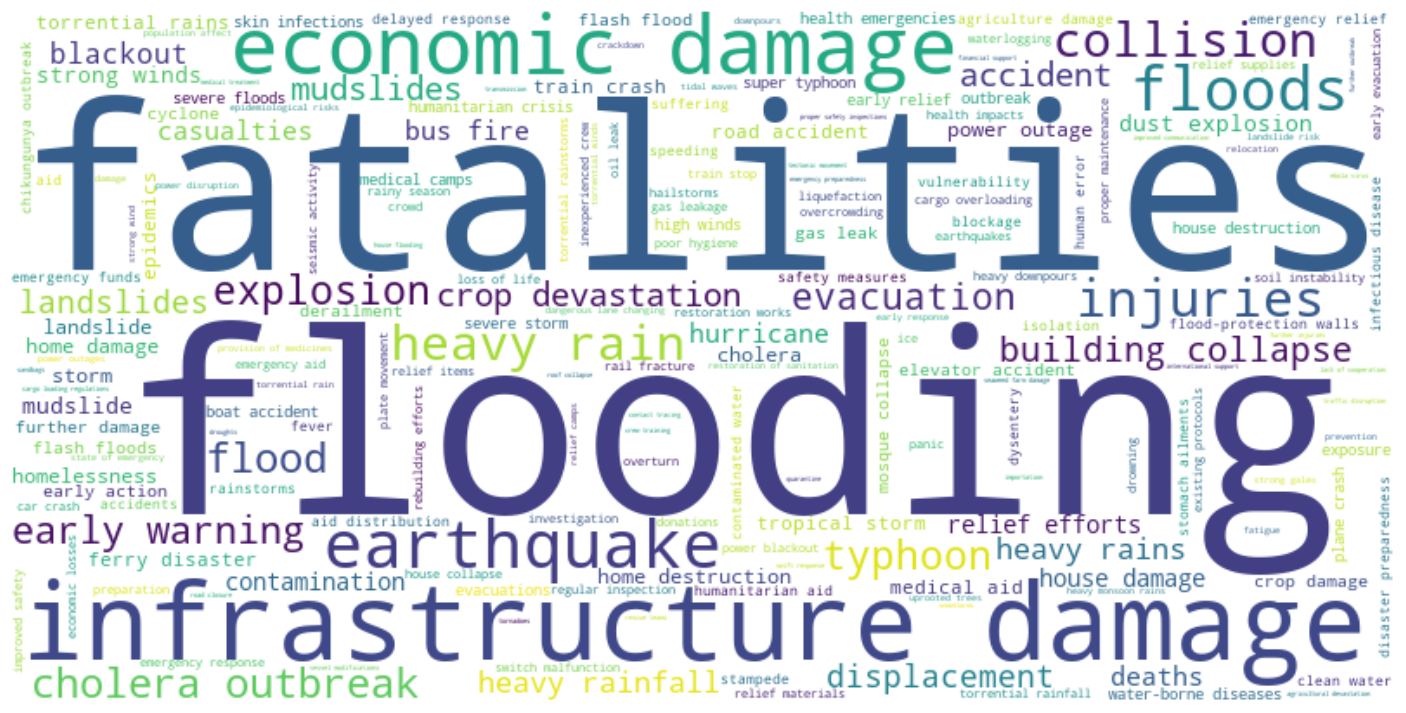

In [235]:
# Count the frequency of each node
node_counts = Counter(all_nodes)

# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(node_counts)

# Plot the word cloud
plt.figure(figsize=(18, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis
#plt.title('Word Cloud of Nodes')
plt.savefig("./data/cloud.png")

plt.show()

/tmp/ipykernel_177/2234745332.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab20', len(aggregated_data)).colors


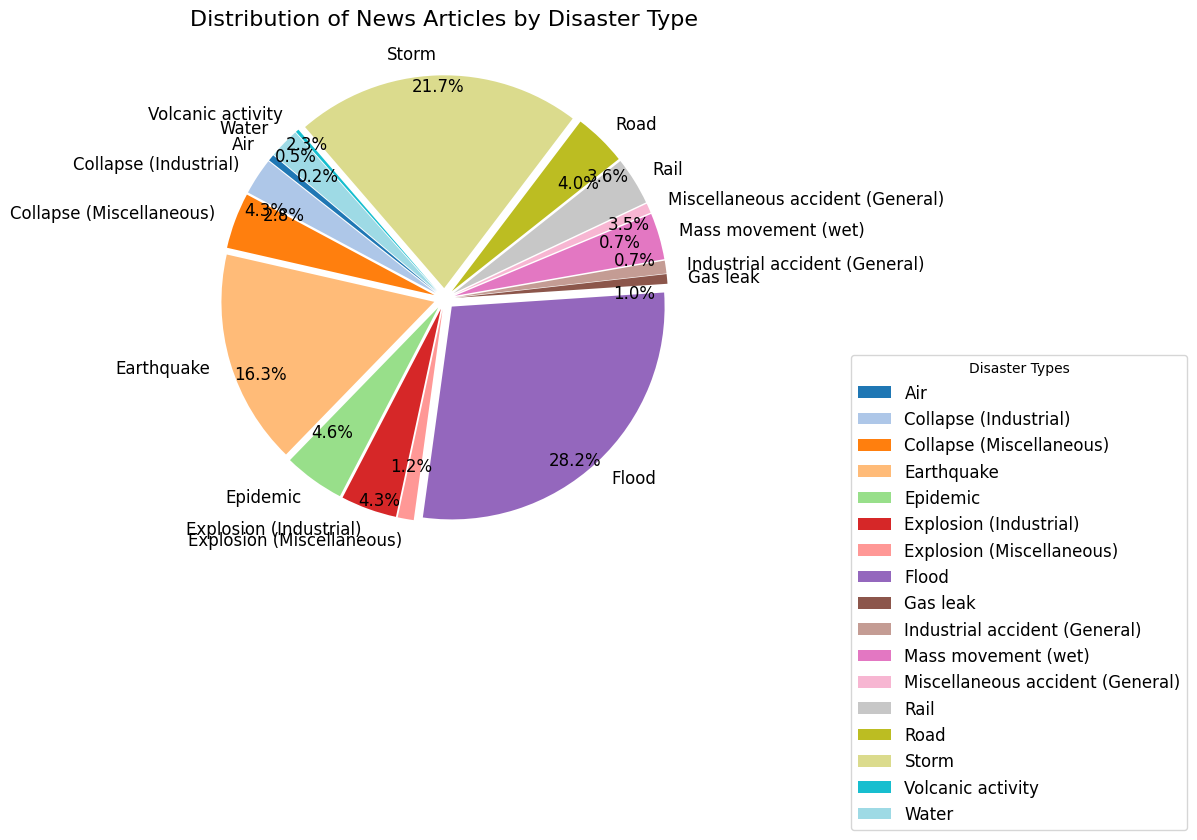

In [227]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm


# Aggregate the number of news articles by disaster type
aggregated_data = prova.groupby("Disaster Type")["nNews"].sum()

# Define a distinct color palette
colors = cm.get_cmap('tab20', len(aggregated_data)).colors

# Define explode to slightly separate each slice
explode = [0.05] * len(aggregated_data)

# Plot pie chart
plt.figure(figsize=(12, 8))
wedges, texts, autotexts = plt.pie(aggregated_data, labels=aggregated_data.index, autopct='%1.1f%%', startangle=140, 
                                   colors=colors, explode=explode, textprops={'fontsize': 12}, pctdistance=0.85)

# Adjust the title
plt.title('Distribution of News Articles by Disaster Type', fontsize=16, pad=20)

# Adjust the position of the labels
for i, a in enumerate(autotexts):
    a.set_position((a.get_position()[0], a.get_position()[1] + (0.1 if i % 2 == 0 else -0.1)))

# Add a legend outside the pie
plt.legend(wedges, aggregated_data.index, title="Disaster Types", loc="upper left", bbox_to_anchor=(1, 0, 1.5, 0.4), fontsize=12)

# Ensure the pie chart is a perfect circle
plt.axis('equal')

# Show the plot with a tight layout
plt.tight_layout()
plt.savefig("./data/newsdistri.png")
plt.show()
